<a href="https://colab.research.google.com/github/ravi-gopalan/fraud_detection_autoencoders/blob/master/fraud_detection_autoencoders_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone the entire repo.
!git clone -l -s git://github.com/ravi-gopalan/fraud_detection_autoencoders.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 76 (delta 0), reused 0 (delta 0), pack-reused 73
Receiving objects: 100% (76/76), 69.44 MiB | 51.23 MiB/s, done.
Resolving deltas: 100% (40/40), done.
/content/cloned-repo
data				      LICENSE	README.md
fraud_detection_autoencoders_1.ipynb  logs
fraud_detection.ipynb		      model.h5


In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [4]:
cd /root

/root


In [0]:
!mkdir .kaggle

In [0]:
!ls

In [0]:
!cp '/gdrive/My Drive/Colab_stuff/kaggle.json' '/root/.kaggle/kaggle.json'
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
cd /content

/content


In [11]:
!kaggle competitions download -c ieee-fraud-detection

 90% 47.0M/52.5M [00:00<00:00, 96.3MB/s]
100% 52.5M/52.5M [00:00<00:00, 151MB/s] 
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 99.5MB/s]
100% 47.3M/47.3M [00:00<00:00, 84.4MB/s]

  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 200MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 160MB/s]


In [9]:
!kaggle --version

Kaggle API 1.5.4


In [12]:
pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [16]:
cd /content/cloned-repo/

/content/cloned-repo


In [17]:
!ls

data				      LICENSE	README.md
fraud_detection_autoencoders_1.ipynb  logs
fraud_detection.ipynb		      model.h5


In [22]:
!unzip /content/cloned-repo/data/creditcardfraud.zip

Archive:  /content/cloned-repo/data/creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [25]:
df = pd.read_csv('/content/cloned-repo/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


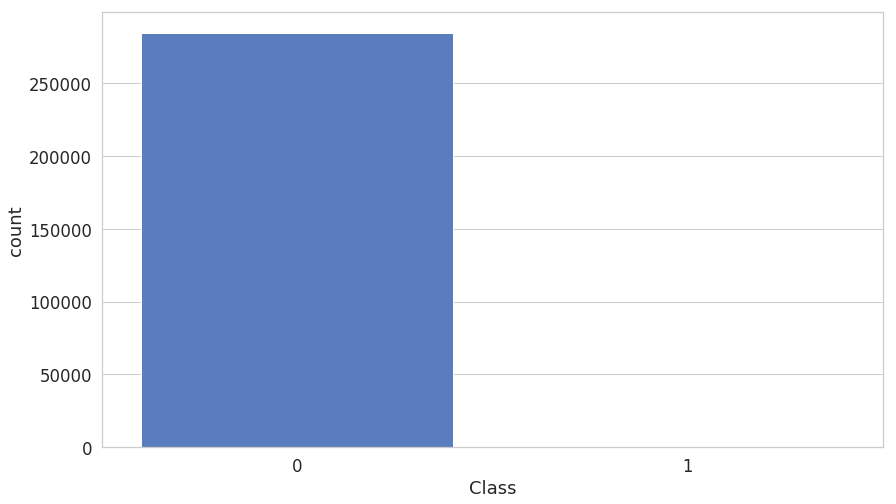

In [33]:
sns.countplot(df['Class'])

In [34]:
df.shape

(284807, 31)

In [35]:
df.isnull().values.any()

False

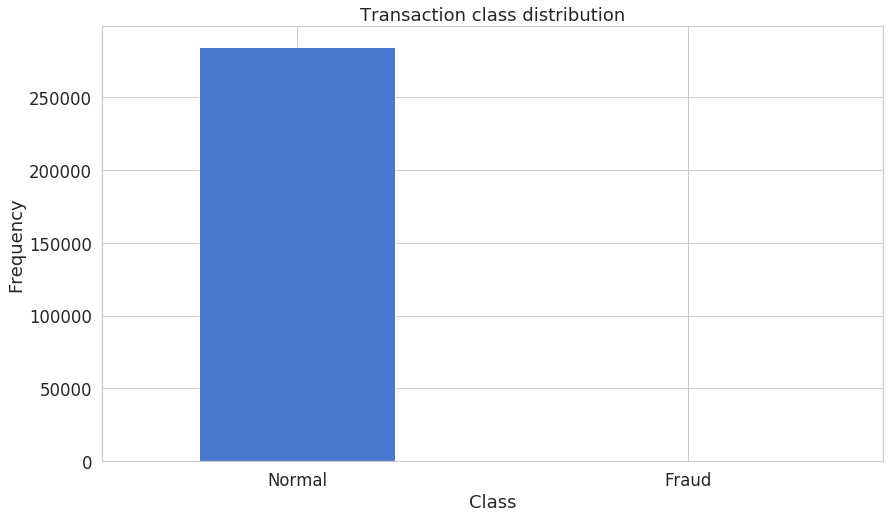

In [46]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [47]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
print(frauds.shape, normal.shape)


(492, 31) (284315, 31)


In [48]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [49]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

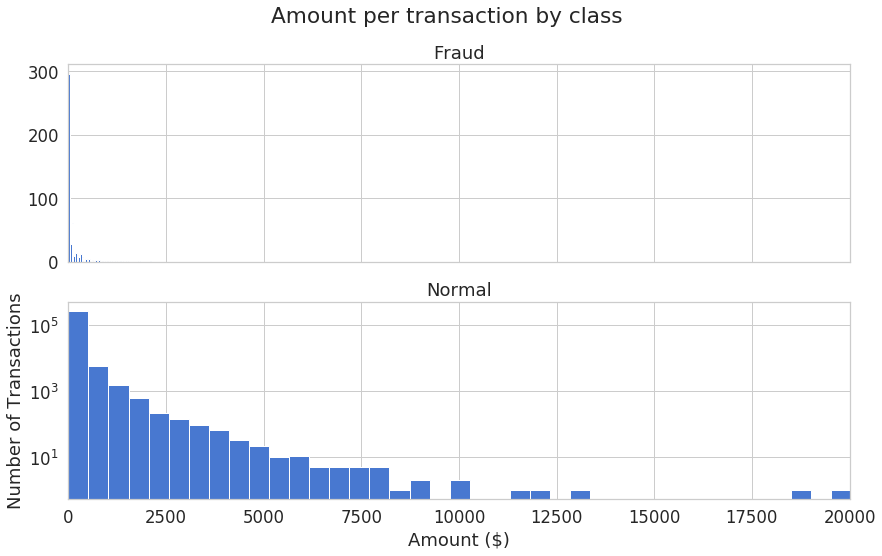

In [50]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

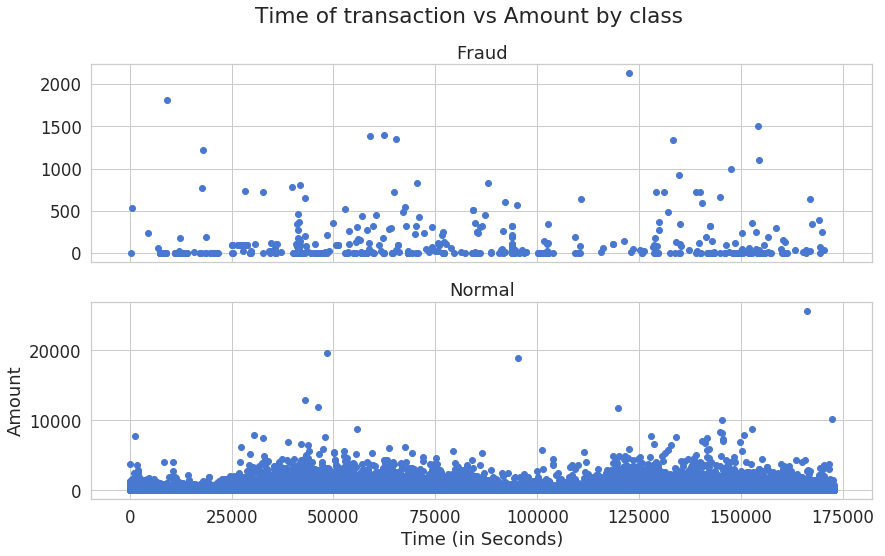

In [51]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [0]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [53]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 29)

In [54]:
input_dim = X_train.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [55]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history





Train on 227451 samples, validate on 56962 samples







Epoch 1/100
227451/227451 [==============================] - 41s 179us/step - loss: 0.8200 - acc: 0.5696 - val_loss: 0.7924 - val_acc: 0.6271

Epoch 2/100
227451/227451 [==============================] - 40s 174us/step - loss: 0.7530 - acc: 0.6360 - val_loss: 0.7769 - val_acc: 0.6444
Epoch 3/100
227451/227451 [==============================] - 39s 170us/step - loss: 0.7420 - acc: 0.6465 - val_loss: 0.7718 - val_acc: 0.6545
Epoch 4/100
227451/227451 [==============================] - 39s 172us/step - loss: 0.7355 - acc: 0.6566 - val_loss: 0.7641 - val_acc: 0.6576
Epoch 5/100
227451/227451 [==============================] - 40s 175us/step - loss: 0.7320 - acc: 0.6589 - val_loss: 0.7624 - val_acc: 0.6605
Epoch 6/100
227451/227451 [==============================] - 39s 173us/step - loss: 0.7297 - acc: 0.6618 - val_loss: 0.7652 - val_acc: 0.6619
Epoch 7/100
227451/227451 [==============================] - 39s 173us/step - loss: 0

In [0]:
autoencoder = load_model('model.h5')

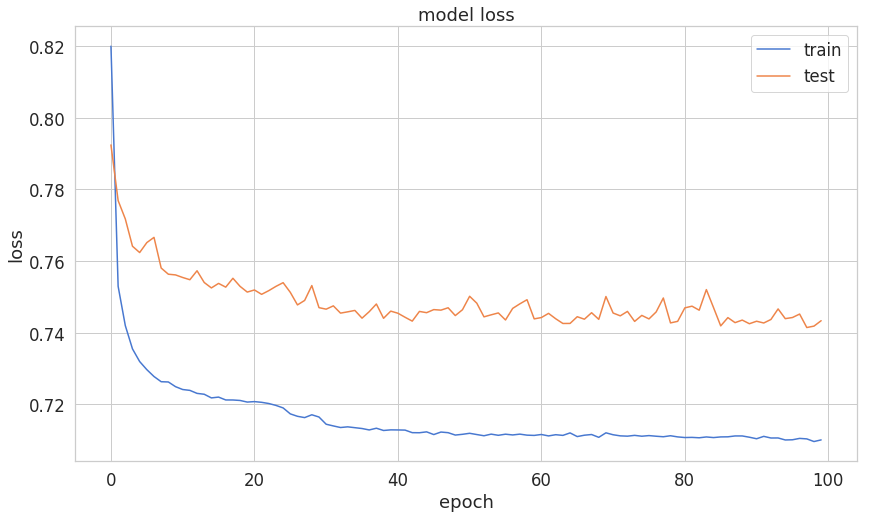

In [57]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [58]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.733220,0.001720
std,3.400876,0.041443
min,0.053478,0.000000
25%,0.241351,0.000000
50%,0.393648,0.000000
75%,0.624136,0.000000
max,263.721127,1.000000


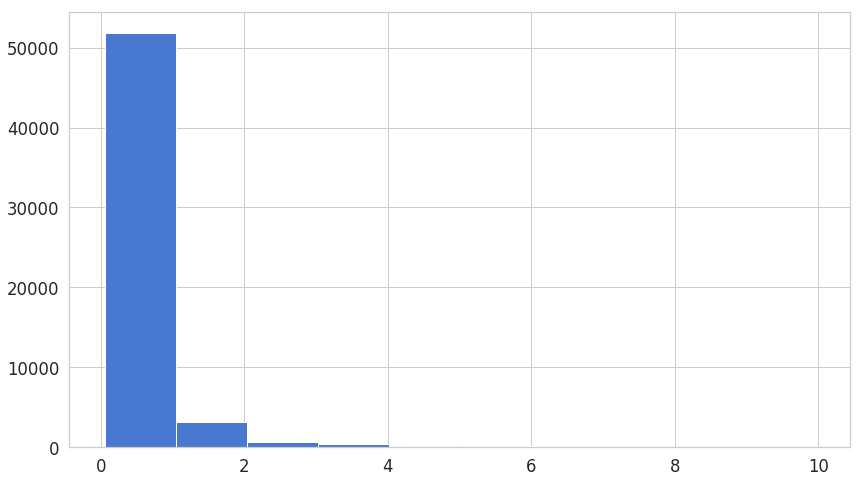

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

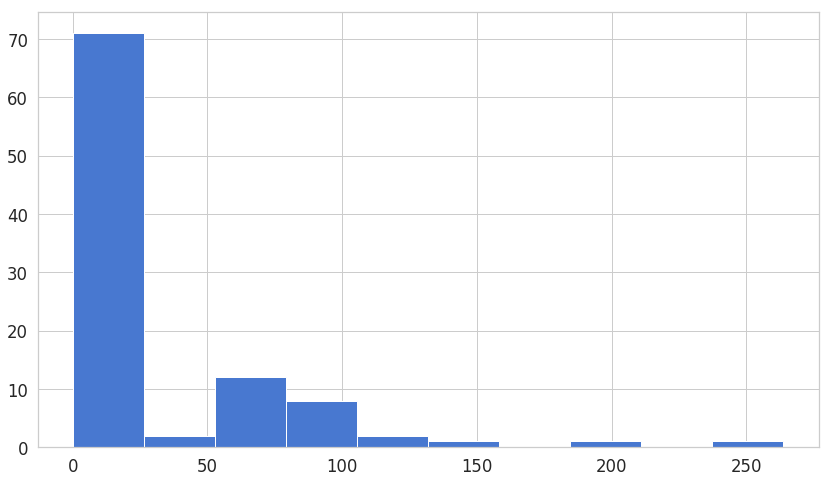

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [0]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

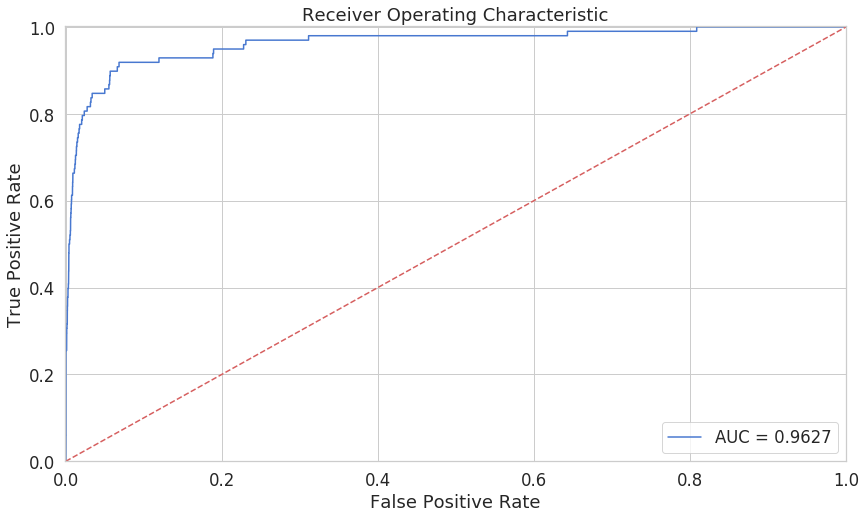

In [62]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

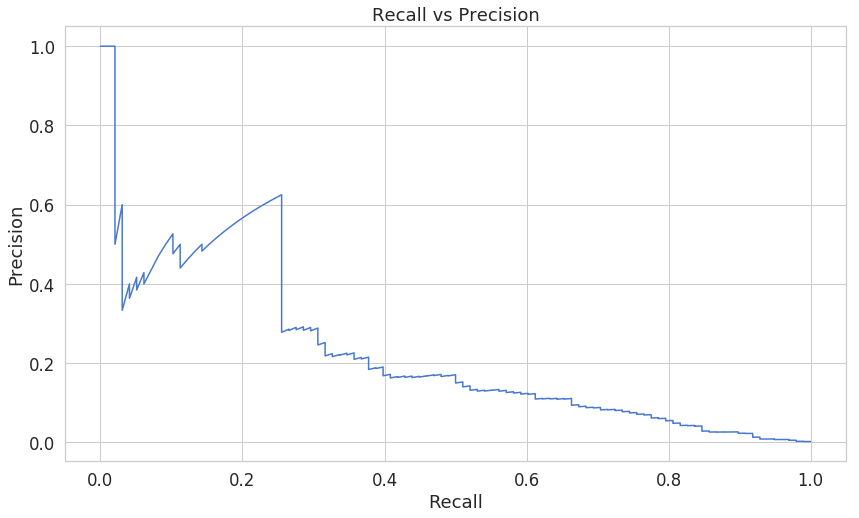

In [64]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

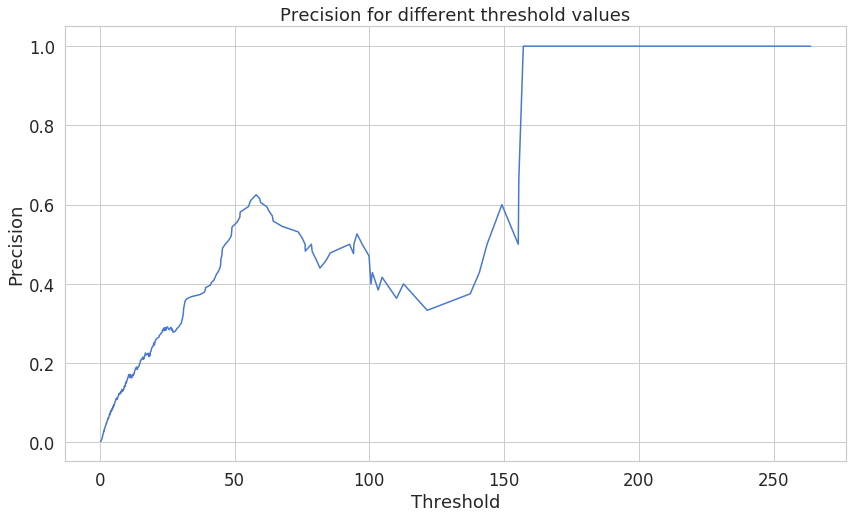

In [65]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

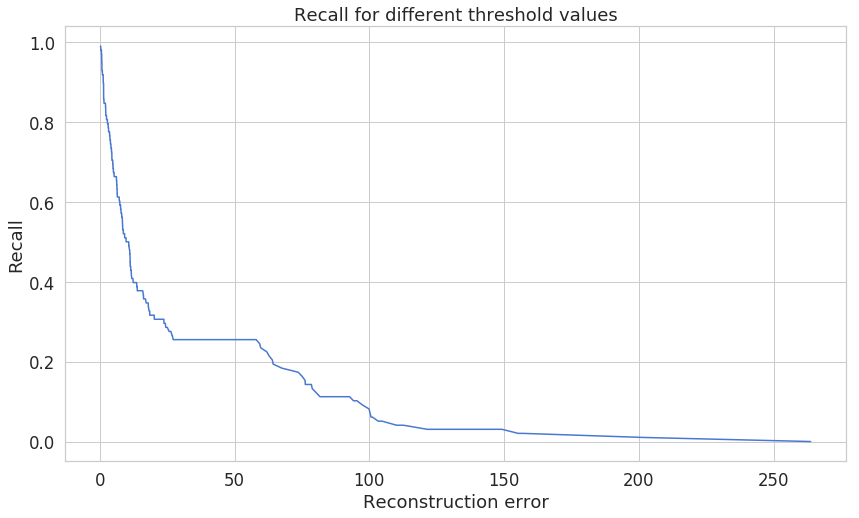

In [66]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [0]:
threshold = 2.9

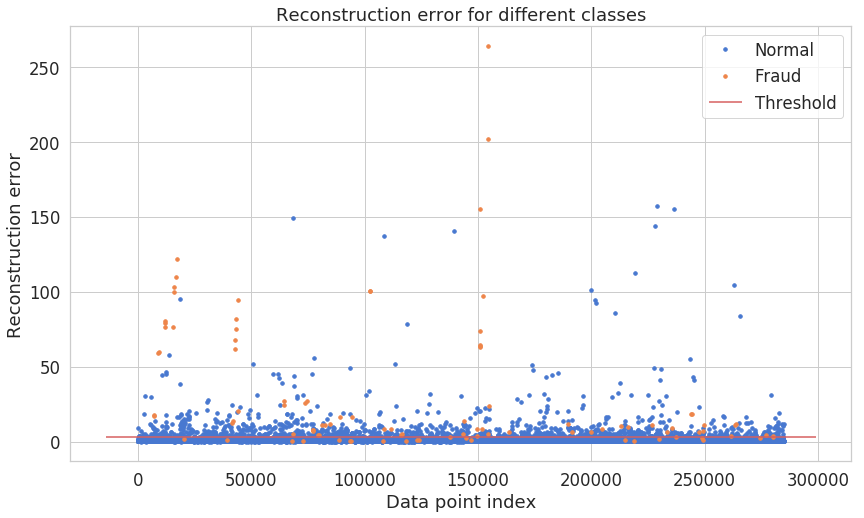

In [68]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

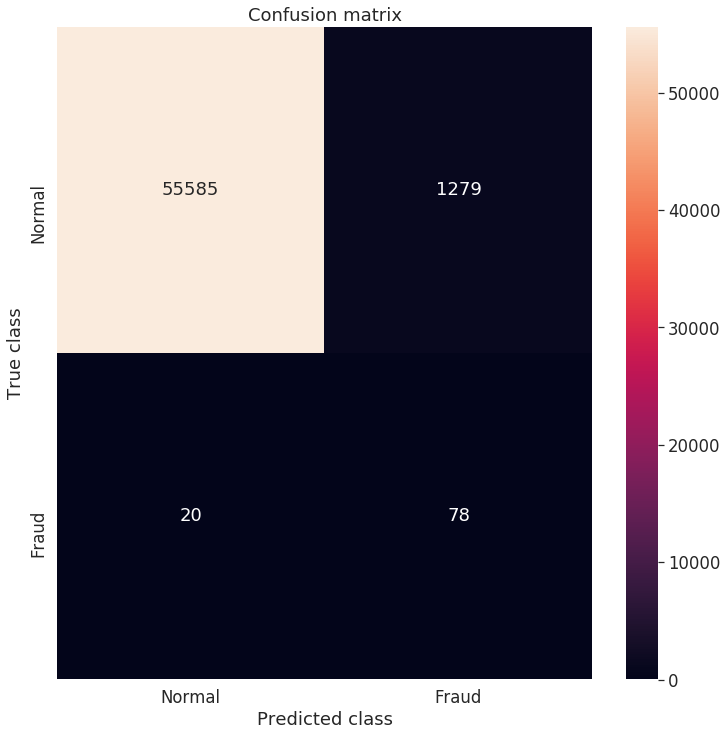

In [69]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


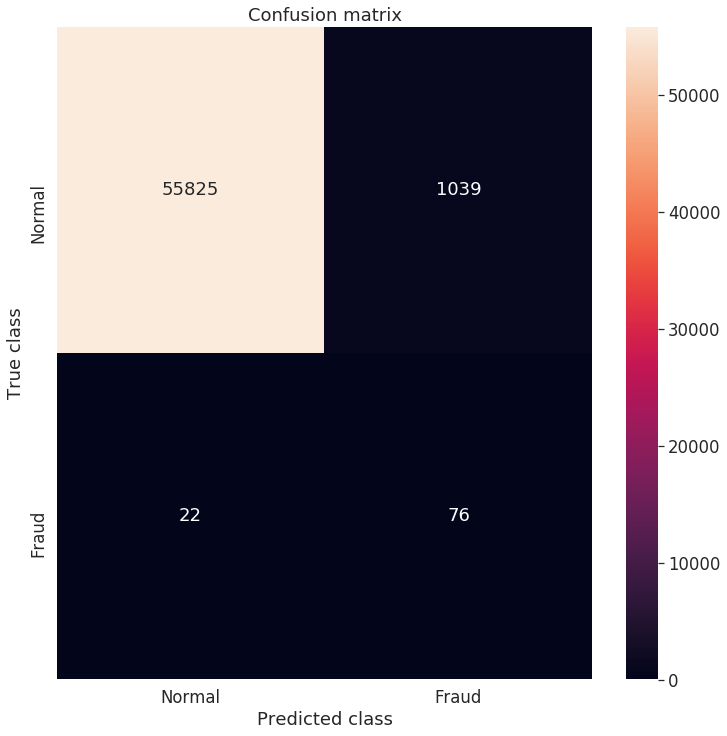

In [71]:
threshold = 3.5

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [100]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (29 -> encoding_dim)
        self.encoder = nn.Sequential(nn.Linear(29, 14),
                                     nn.Tanh(),
                                     nn.Linear(14,7),
                                     nn.ReLU())

        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.decoder = nn.Sequential(nn.Linear(7, 7),
                                     nn.Tanh(),
                                     nn.Linear(7,29),
                                     nn.ReLU())      

    def forward(self, x):
        # define feedforward behavior
        x = self.encoder(x)
        # and scale the *output* layer with a sigmoid activation function
        x = self.decoder(x)
        return x

# initialize the NN
encoding_dim = 14
model = Autoencoder().double()
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=29, out_features=14, bias=True)
    (1): Tanh()
    (2): Linear(in_features=14, out_features=7, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=7, out_features=7, bias=True)
    (1): Tanh()
    (2): Linear(in_features=7, out_features=29, bias=True)
    (3): ReLU()
  )
)


In [0]:
from torch.utils.data import DataLoader
import torch.utils.data as data_utils

In [0]:
n_epochs = 100
mini_batch_size = 64
learning_rate = 1e-3

In [0]:
train_loader = data_utils.DataLoader(X_train, batch_size=mini_batch_size, shuffle=True)

In [0]:
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [0]:
import torch

In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)

In [0]:
history = {}
history['train_loss'] = []
history['test_loss'] = []

In [102]:
for epoch in range(n_epochs):
    h = np.array([])
    for data in train_loader:
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, n_epochs, mean_loss))
    history['train_loss'].append(mean_loss)
    

torch.save(model.state_dict(), 'credit_card_model.pth')

epoch [1/20], loss:0.8657
epoch [2/20], loss:0.7861
epoch [3/20], loss:0.7671
epoch [4/20], loss:0.7585
epoch [5/20], loss:0.7234
epoch [6/20], loss:0.7174
epoch [7/20], loss:0.7155
epoch [8/20], loss:0.7136
epoch [9/20], loss:0.7118
epoch [10/20], loss:0.7099
epoch [11/20], loss:0.7075
epoch [12/20], loss:0.7058
epoch [13/20], loss:0.7048
epoch [14/20], loss:0.7041
epoch [15/20], loss:0.7039
epoch [16/20], loss:0.7034
epoch [17/20], loss:0.7033
epoch [18/20], loss:0.7030
epoch [19/20], loss:0.7027
epoch [20/20], loss:0.7023


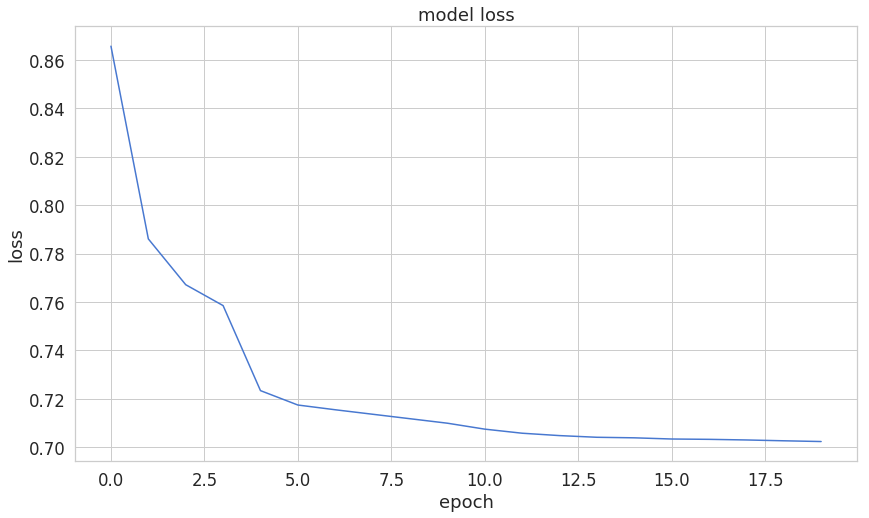

In [103]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.axis([0,100,0.69,0.80])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [0]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

In [105]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,56962.000000,11325.000000
mean,0.734102,0.001943
std,3.470243,0.044034
min,0.042690,0.000000
25%,0.230409,0.000000
50%,0.383698,0.000000
75%,0.620928,0.000000
max,260.252023,1.000000


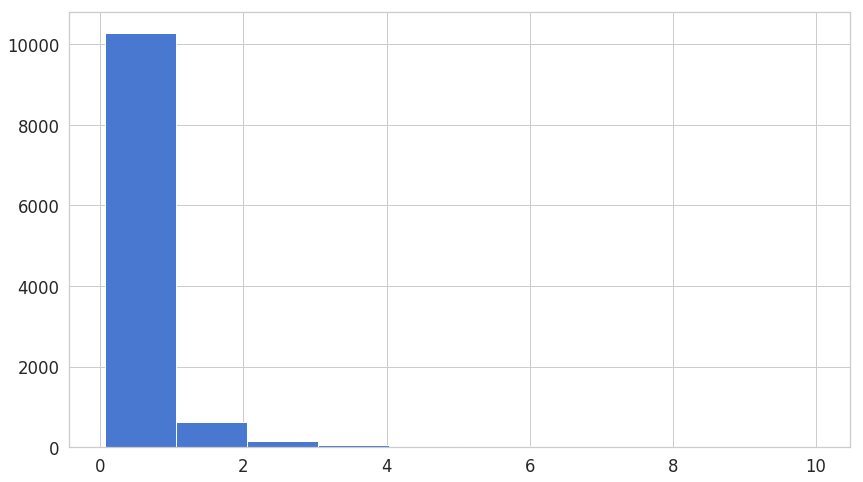

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

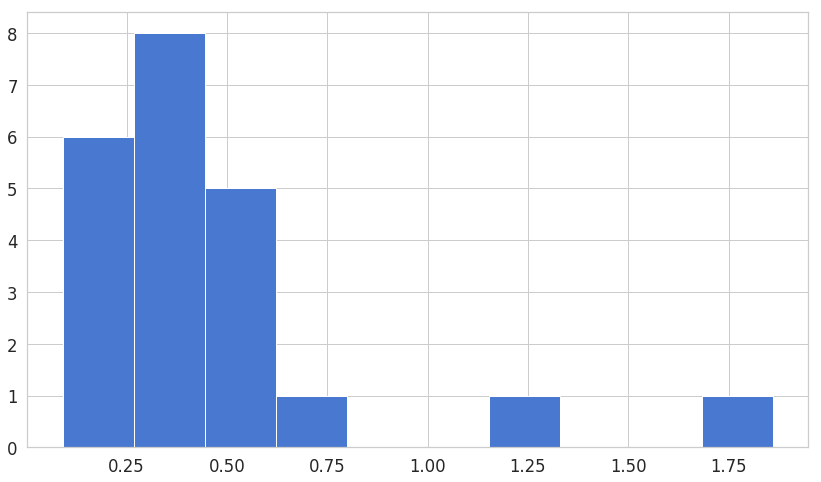

In [108]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

In [116]:
reconstructionErrorDF[np.isnan(reconstructionErrorDF.pred_loss)]

,pred_loss,Class


In [109]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

ValueError: ignored